# Time Series Forecasting 

### Table of Contents:
Models:
* [Exponential Smoothing](#Exponential-Smoothing)
* [ARIMA](#ARIMA)
* [Gradient Boosted Trees](#lightgbm)
* [Neural Networks](#neural-networks)

Other Topics:
* [Matrix Profiles (Pattern and Anomoly Detection)](#Matrix-Profiles)
* [Box-Cox Transform](#box-cox)
* [Portmanteau Test](#Portmanteau-Test)

References:
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
* [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm#pdq)
* [statsmodels.org](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html)

### Generate Data with linear trend with a cyclic pattern and random noise

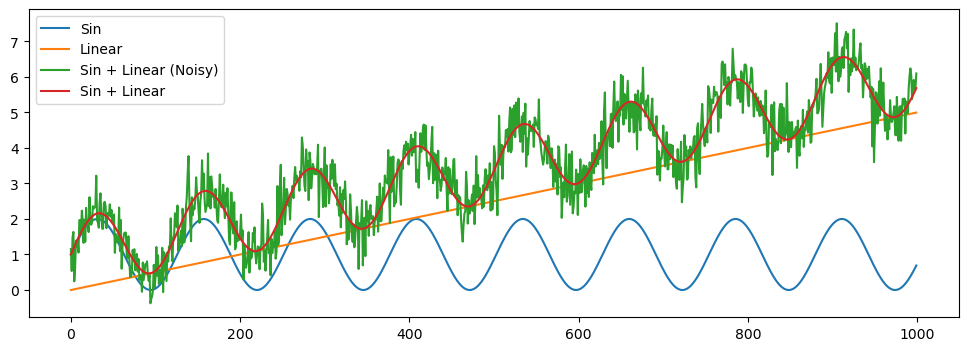

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import lightgbm as lgb

FIGSIZE = (12, 4)

data_size = 1000
sin = 1 + np.sin(np.arange(data_size)*.05)
linear = np.arange(data_size)*.005
data = sin + linear

rng = np.random.default_rng(42)
noisy_data = data + rng.normal(scale=0.5, size=data_size)

# Split the data into train and test sets
train_size = int(data_size * 0.8)
test_size = data_size - train_size
train, test = data[:train_size], data[train_size:]
noisy_train, noisy_test = noisy_data[:train_size], noisy_data[train_size:]

plt.figure(figsize=FIGSIZE)
plt.plot(sin, label='Sin')
plt.plot(linear, label='Linear')
plt.plot(noisy_data, label='Sin + Linear (Noisy)')
plt.plot(data, label='Sin + Linear')
plt.legend()
plt.show()

### Seasonality 
This is data dependent. For example, if you have daily data and a weekly trend in the data, then the seasonality parameter will be 7.

Here I find the seasonality by looking at when the sin function repeats.

Average distance between peaks: 126


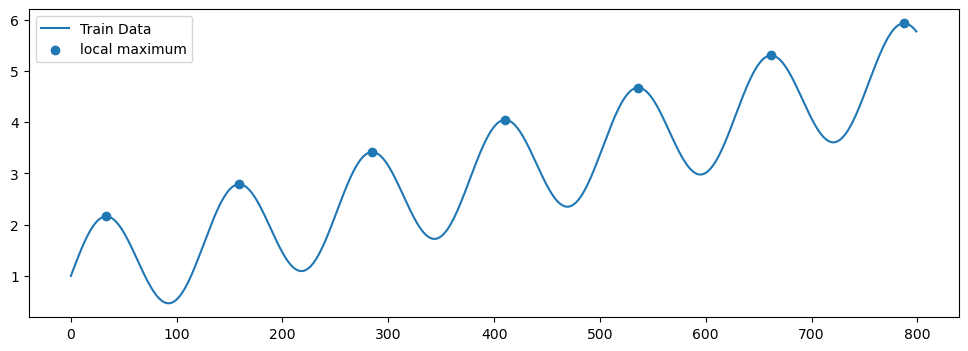

In [2]:
peaks = [i for i in range(1, len(train)-1) if train[i] > train[i-1] and train[i] > train[i+1]]
window_size = round(sum(list(map(lambda x1, x2: x2-x1, peaks[:-1], peaks[1:]))) / len(peaks[:-1]))
print(f"Average distance between peaks: {window_size}")
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.scatter(peaks, train[peaks], label='local maximum')
plt.legend()
plt.show()

## Exponential Smoothing <a name="Exponential-Smoothing"></a>
$ S_t = \alpha  y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $

<br>
Simple exponential smoothing won't be able to capture any of the trends on the data :(

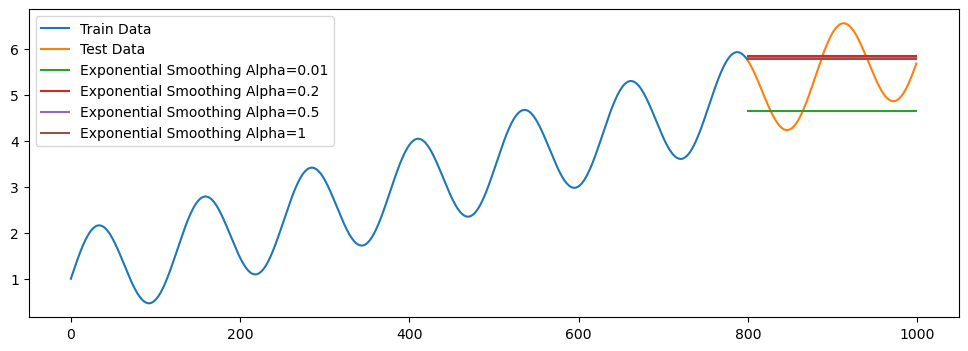

In [3]:
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')

for alpha in [0.01, 0.2, 0.5, 1]:
    exp_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    exp_smoothing_forecast = exp_model.forecast(test_size)
    plt.plot(np.arange(train_size, data_size), exp_smoothing_forecast, label=f'Exponential Smoothing Alpha={alpha}')

plt.legend()
plt.show()

### Exponential smoothing with seasonality (Holt-Winters)


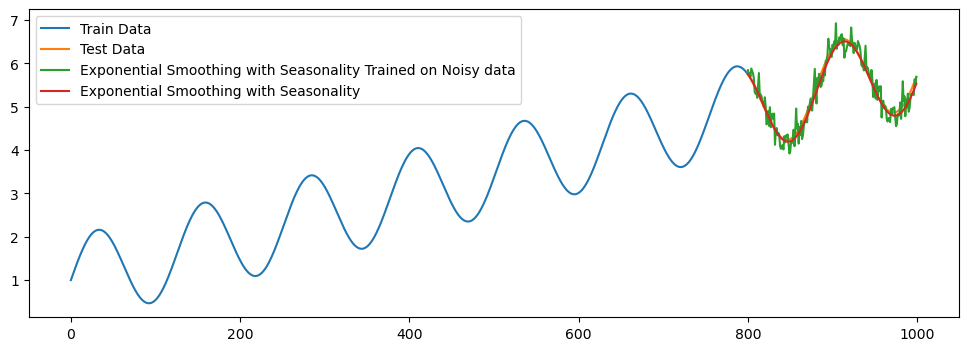

In [4]:
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')

exp_model = ExponentialSmoothing(noisy_train,
                seasonal_periods=window_size,
                trend="add",
                seasonal="add").fit()
exp_smoothing_forecast = exp_model.forecast(test_size)
plt.plot(np.arange(train_size, len(data)), exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality Trained on Noisy data')

exp_model = ExponentialSmoothing(train,
                seasonal_periods=window_size,
                trend="add",
                seasonal="add").fit()
exp_smoothing_forecast = exp_model.forecast(test_size)
plt.plot(np.arange(train_size, len(data)), exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality')
plt.legend()
plt.show()

### Model decomposition

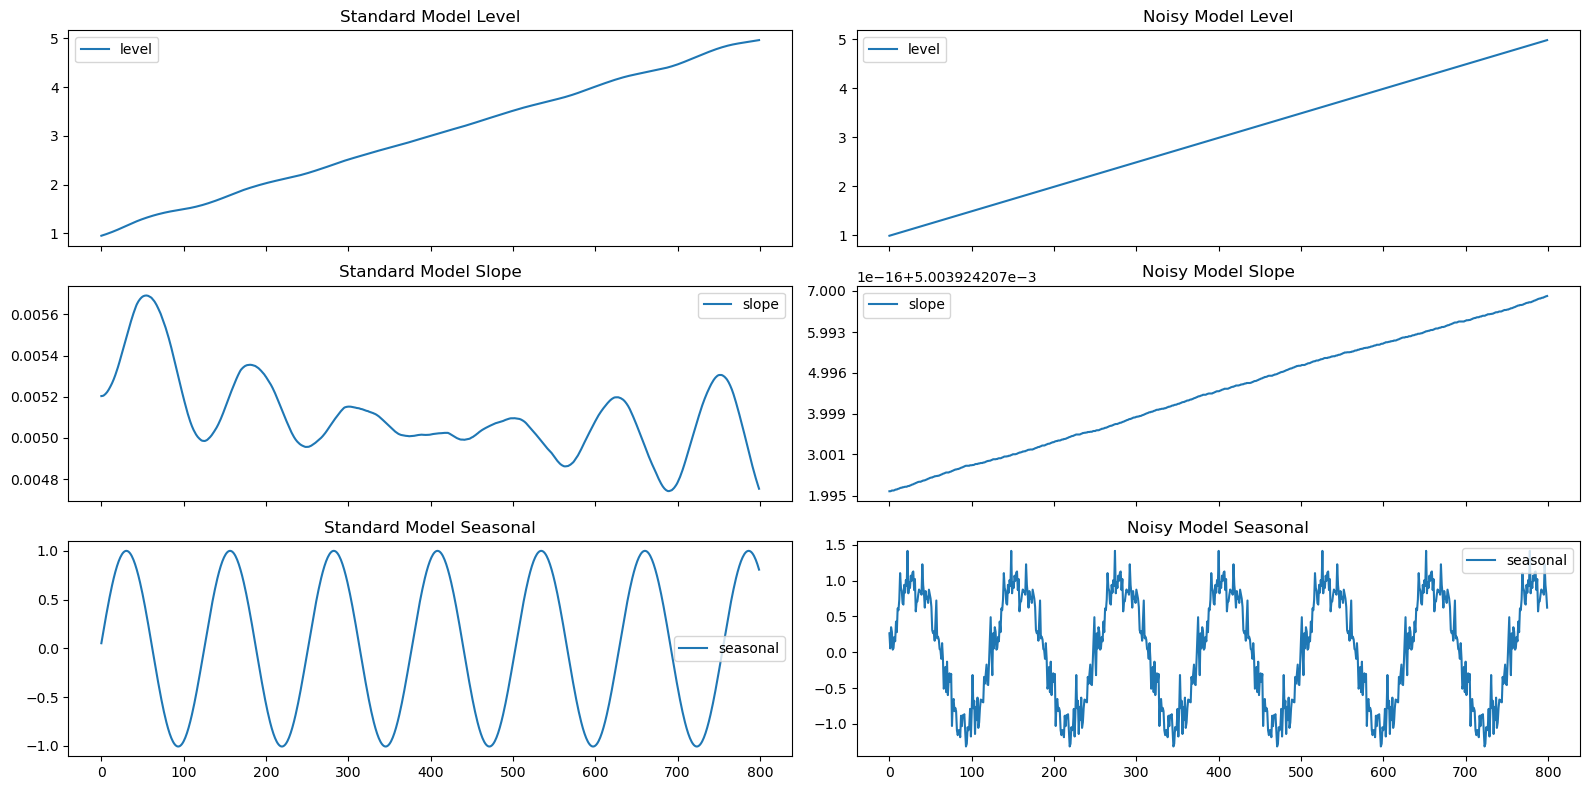

In [5]:
noisy_exp_model = ExponentialSmoothing(noisy_train,
                seasonal_periods=window_size,
                trend="add",
                seasonal="add").fit()

exp_model = ExponentialSmoothing(train,
                seasonal_periods=window_size,
                trend="add",
                seasonal="add").fit()

# Create data frames for each model
noisy_states = pd.DataFrame(
    np.c_[noisy_exp_model.level, noisy_exp_model.trend, noisy_exp_model.season],
    columns=["level", "slope", "seasonal"]
)

standard_states = pd.DataFrame(
    np.c_[exp_model.level, exp_model.trend, exp_model.season],
    columns=["level", "slope", "seasonal"]
)

fig, axes = plt.subplots(3, 2, figsize=(16, 8), sharex=True)
standard_states[["level"]].plot(ax=axes[0, 0], title="Standard Model Level")
standard_states[["slope"]].plot(ax=axes[1, 0], title="Standard Model Slope")
standard_states[["seasonal"]].plot(ax=axes[2, 0], title="Standard Model Seasonal")
noisy_states[["level"]].plot(ax=axes[0, 1], title="Noisy Model Level")
noisy_states[["slope"]].plot(ax=axes[1, 1], title="Noisy Model Slope")
noisy_states[["seasonal"]].plot(ax=axes[2, 1], title="Noisy Model Seasonal")
plt.tight_layout()
plt.show()

## ARIMA / SARIMAX(p, d, q)x(P, D, Q, s) <a name="ARIMA"></a>

Parameters:
* **AutoRegressive (p)**: Relationship between an observation and a certain number of lagged observations (previous time steps). The parameter p determines the number of lag observations included in the model.
* **Integrated (d)**: Order of differencing required to make the series stationary. Differencing is the transformation of a time series to remove trends and seasonality, and d is the number of times the differencing operation is performed.
* **Moving Average (q)**: Relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter q specifies the number of terms.

Seasonal components:
* **Seasonal AR (P)**: Similar to the AR but apply to the seasonal component of the series. The parameter P specifies the number of seasonal autoregressive terms.
* **Seasonal differencing order (D)**: How many seasonal differences are needed to make the series stationary.
* **Seasonal MA (Q)**: MA for the seasonal differences. Q specifies the number of seasonal moving average terms.
* **Seasonal period (s)**: Length of the seasonal cycle. E.g. s=12 for monthly data with an annual cycle.

Other:
* **Exogenous variables (X)**: External variables that influence the forecast but are not predicted by the model. They can include any variable thought to affect the dependent variable, such as economic indicators, weather conditions, etc.

ARIMA(0,1,1) without constant = simple exponential smoothing


/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


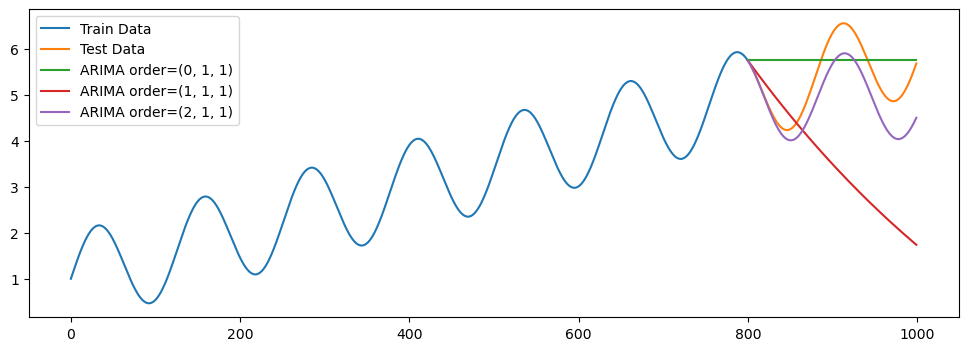

In [6]:
def ARIMA_forecast(model):
    arima_fit = model.fit(method_kwargs={"warn_convergence": False})
    return arima_fit.forecast(len(test))

plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(data)), test, label='Test Data')
plt.plot(np.arange(train_size, len(data)), ARIMA_forecast(ARIMA(train, order=(0, 1, 1))), label='ARIMA order=(0, 1, 1)')
plt.plot(np.arange(train_size, len(data)), ARIMA_forecast(ARIMA(train, order=(1, 1, 1))), label='ARIMA order=(1, 1, 1)')
plt.plot(np.arange(train_size, len(data)), ARIMA_forecast(ARIMA(train, order=(2, 1, 1))), label='ARIMA order=(2, 1, 1)')
plt.legend()
plt.show()

In [7]:
# arima_model = ARIMA(train, order=(1, 1, 1))
arima_model = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, window_size))
arima_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
arima_forecast = arima_fit.forecast(len(test))

plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(data)), test, label='Test Data')
plt.plot(np.arange(train_size, len(data)), arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 

In [ ]:
# sarimax_model = SARIMAX(train, order=(2, 1, 1))
# sarimax_fit = sarimax_model.fit()
# sarimax_forecast = sarimax_fit.forecast(len(test))
# plt.plot(np.arange(train_size, len(data)), sarimax_forecast, label='SARIMAX Forecast')
# plt.plot(np.arange(train_size, len(data)), test, label='Test Data')

## LightGBM <a name="lightgbm"></a>
We can turn the forecasting data into tabular form by creating lag features.

Tree based models cannot make predictions outside of the training data. Below we see the result of this by finding that the model won't predict a value higher than what was previously observed

In [ ]:
'''
Parameter Tuning
'''
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'boosting_type': ['gbdt', 'dart'],
#     'metric': ['l2'],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'num_leaves': [5, 10, 20, 40],
#     'feature_fraction': [0.5, 0.9, 0.95, 1],
#     'bagging_fraction': [0.5, 0.9, 0.95, 1],
#     'lambda_l1': [0, 0.1, 0.2],
#     'lambda_l2': [0, 0.1, 0.2],
#     'min_gain_to_split': [0.01, 0.1, 0.2],
#     'verbose': [-1]
# }

# gbm = lgb.LGBMRegressor()
# grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters found by grid search are:", grid_search.best_params_)

,data,t_1,t_2,t_3,t_4
0,1.000000,NaN,NaN,NaN,NaN
1,1.054979,1.000000,NaN,NaN,NaN
2,1.109833,1.054979,1.000000,NaN,NaN
3,1.164438,1.109833,1.054979,1.000000,NaN
4,1.218669,1.164438,1.109833,1.054979,1.0


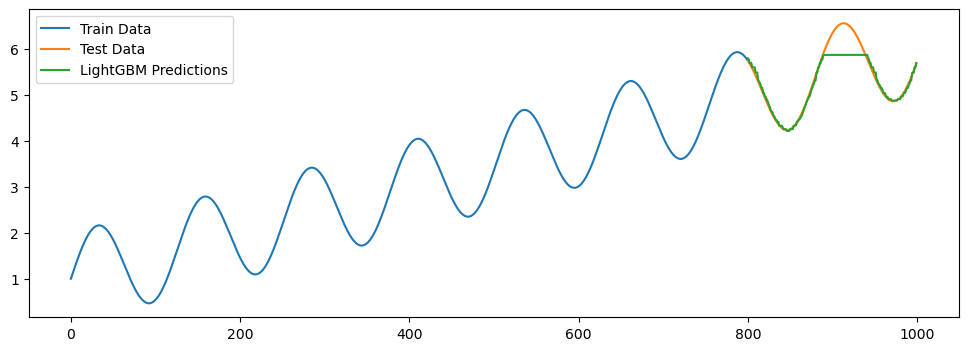

In [105]:
df = pd.DataFrame({'data': data})
for lag in range(1, 5):
    df[f't_{lag}'] = df['data'].shift(lag)

X = df.drop('data', axis=1)
y = df['data']

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

display(df.head())

params = {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(params, lgb_train)
predictions = gbm.predict(X_test)

plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')
plt.plot(np.arange(train_size, data_size), predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

,data,t_1,t_2,t_3,t_4
0,1.152359,NaN,NaN,NaN,NaN
1,0.534987,1.152359,NaN,NaN,NaN
2,1.485059,0.534987,1.152359,NaN,NaN
3,1.634720,1.485059,0.534987,1.152359,NaN
4,0.243152,1.634720,1.485059,0.534987,1.152359


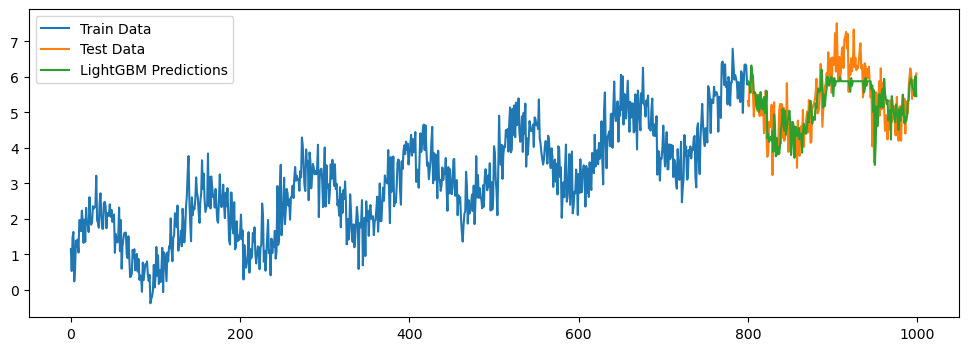

In [104]:
df = pd.DataFrame({'data': noisy_data})
for lag in range(1, 5):
    df[f't_{lag}'] = df['data'].shift(lag)

X = df.drop('data', axis=1)
y = df['data']

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

display(df.head())

params = {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(params, lgb_train)
predictions = gbm.predict(X_test)

plt.figure(figsize=FIGSIZE)
plt.plot(noisy_train, label='Train Data')
plt.plot(np.arange(train_size, data_size), noisy_test, label='Test Data')
plt.plot(np.arange(train_size, data_size), predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

## Neural Networks <a name="neural-networks"></a>
Below is a simple example of using a single RNN layer.

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torch import nn

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class RNNModel(LightningModule):
    def __init__(self, input_size, hidden_size, output_size, seq_length):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.unsqueeze(-1))
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        # self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

def predict(model, data_loader, seq_length):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.unsqueeze(-1).to(model.device)
            pred = model(x)
            predictions.append(pred.item())
    return predictions

# Hyperparameters
seq_length = 20  # Number of time steps to look back
batch_size = 4 #128
hidden_size = 50
num_layers = 1
learning_rate = 0.001
num_epochs = 20

train_dataset = TimeSeriesDataset(train, seq_length)
test_dataset = TimeSeriesDataset(test, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = RNNModel(input_size=1, hidden_size=50, output_size=1, seq_length=seq_length)
trainer = Trainer(max_epochs=20, log_every_n_steps=20)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | rnn  | RNN    | 2.6 K 
1 | fc   | Linear | 51    
--------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 195/195 [00:02<00:00, 70.56it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 195/195 [00:02<00:00, 70.37it/s, v_num=17]


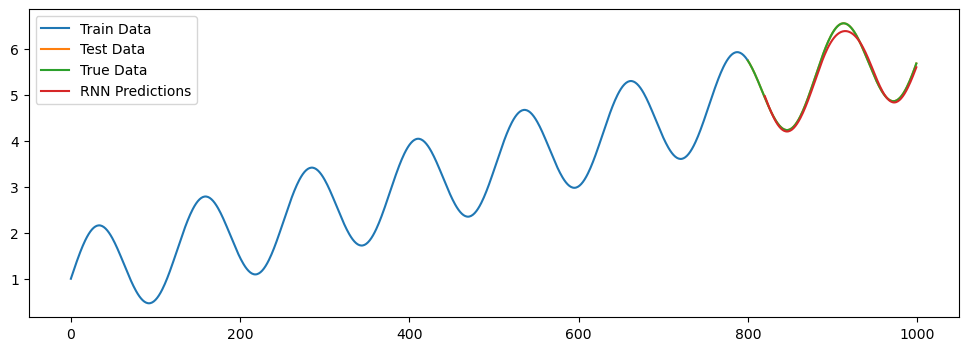

In [13]:
# predictions = predict(model, test_loader, seq_length)
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')
plt.plot(np.arange(train_size, data_size), test, label='True Data')
plt.plot(np.arange(train_size+seq_length, data_size), predict(model, test_loader, seq_length), label='RNN Predictions')
plt.legend()
plt.show()

In [14]:
train_loader = DataLoader(TimeSeriesDataset(noisy_train, seq_length), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(noisy_test, seq_length), batch_size=1, shuffle=False)
model = RNNModel(input_size=1, hidden_size=50, output_size=1, seq_length=seq_length)
trainer = Trainer(max_epochs=20, log_every_n_steps=20)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | rnn  | RNN    | 2.6 K 
1 | fc   | Linear | 51    
--------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 195/195 [00:02<00:00, 75.01it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 195/195 [00:02<00:00, 74.77it/s, v_num=18]


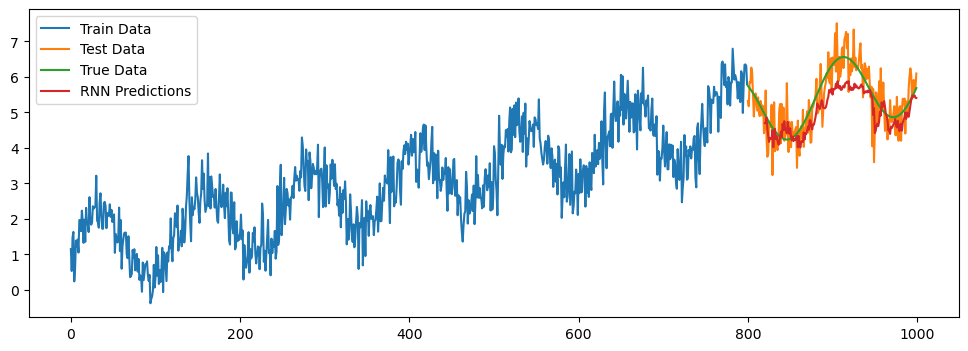

In [15]:
plt.figure(figsize=FIGSIZE)
plt.plot(noisy_train, label='Train Data')
plt.plot(np.arange(train_size, data_size), noisy_test, label='Test Data')
plt.plot(np.arange(train_size, data_size), test, label='True Data')
plt.plot(np.arange(train_size+seq_length, data_size), predict(model, test_loader, seq_length), label='RNN Predictions')
plt.legend()
plt.show()

## Matrix Profiles  <a name="Matrix-Profiles"></a>
* [Stumpy Documentation](https://stumpy.readthedocs.io/en/latest/#)
* [10 Things to Do with Matrix Profiles](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf)

The idea here is that we find the nearest neighbor in the time series based on euclidean distance. We split the data into "windows" that are just smaller chunks of data. For example, if you had daily data and wanted to compare weekly trends, you'd use a window of size 7.

The lowest values are considered a motif (pattern) since they represent the pair of nearest neighbor subsequences with the smallest z-normalized Euclidean distance.

The subsequences that have the highest local values are unique.

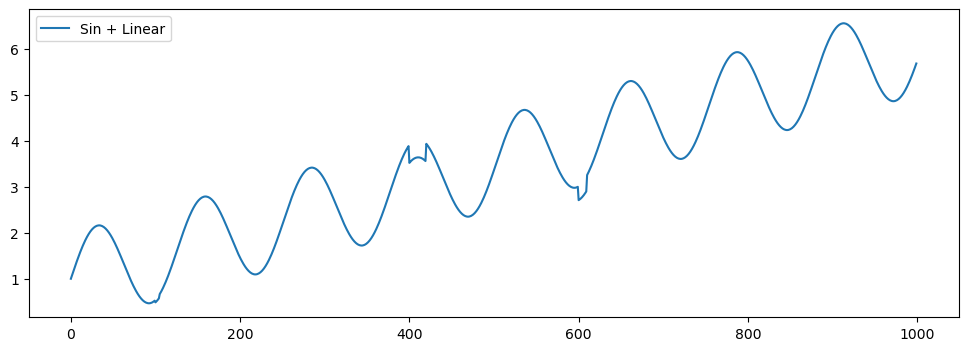

In [74]:
import stumpy
from matplotlib.patches import Rectangle

anomoly_data = data.copy()
for start, end in [(100, 105), (400, 420), (600, 610)]:
    anomoly_data[start:end] = anomoly_data[start:end] * 0.9

plt.figure(figsize=FIGSIZE)
plt.plot(anomoly_data, label='Sin + Linear')
plt.legend()
plt.show()

m = 20 # Originally tried using m = window_size = 126, but this wasn't ideal
matrix_profile = stumpy.stump(anomoly_data, m=10) 

# the first column consists of the matrix profile, 
# the second column consists of the matrix profile indices, 
# the third column consists of the left matrix profile indices, 
# the fourth column consists of the right matrix profile indices.
# mp_df = pd.DataFrame({
#     "matrix_profile": matrix_profile[:,0],
#     "indices": matrix_profile[:,1],
#     "left_indices": matrix_profile[:,2],
#     "right_indices": matrix_profile[:,3]
# })

### Motif / Pattern
The matrix profile allows you to find patterns and also the nearest neighbor for all subsequences.

The motif is located at index 498
The nearest neighbor is located at index 875


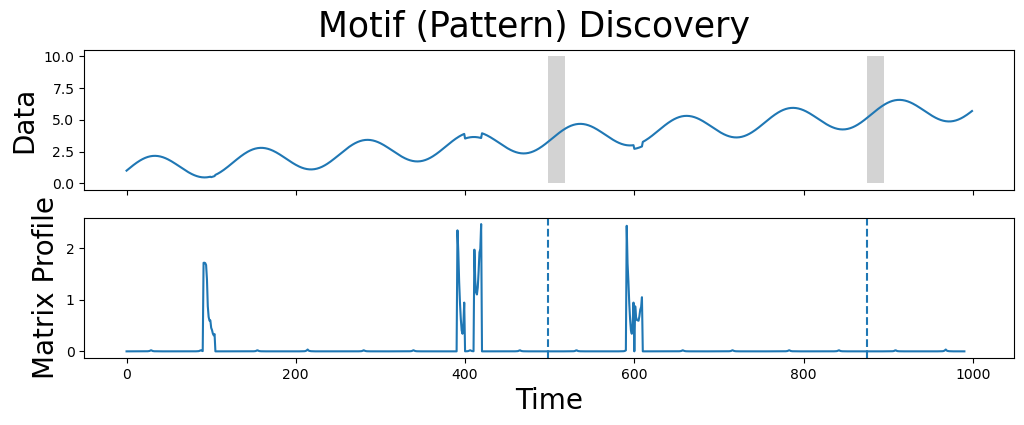

In [77]:
motif_idx = np.argsort(matrix_profile[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = matrix_profile[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].add_patch(Rectangle((motif_idx, 0), m, 10, facecolor='lightgrey'))
axs[0].add_patch(Rectangle((nearest_neighbor_idx, 0), m, 10, facecolor='lightgrey'))
axs[0].set_ylabel('Data', fontsize='20')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

### Potential Anomolies
The subsequence located at this global maximum is referred to as a discord, novelty, or potential anomaly.

The discord is located at index 419
The nearest neighbor subsequence to this discord is 2.459451015269966 units away


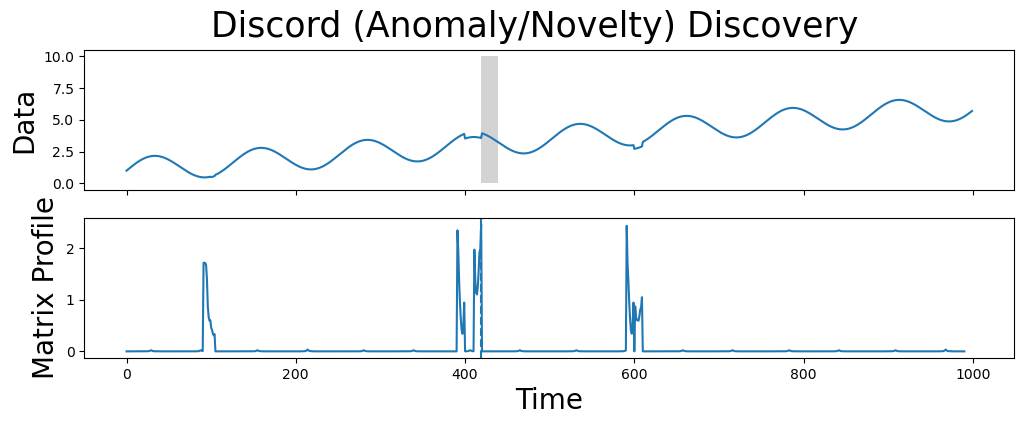

In [78]:
discord_idx = np.argsort(matrix_profile[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")

nearest_neighbor_distance = matrix_profile[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].set_ylabel('Data', fontsize='20')
axs[0].add_patch(Rectangle((discord_idx, 0), m, 10, facecolor='lightgrey'))
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

## Box-Cox Transformation <a name="box-cox"></a>
Transforms the target variable so that data resembles a normal distribution which is assumed by many models.

Cons:
* Harder to interprete
* Usually gives the median of the forecast distribution when we revert the transformed data to its original scale.

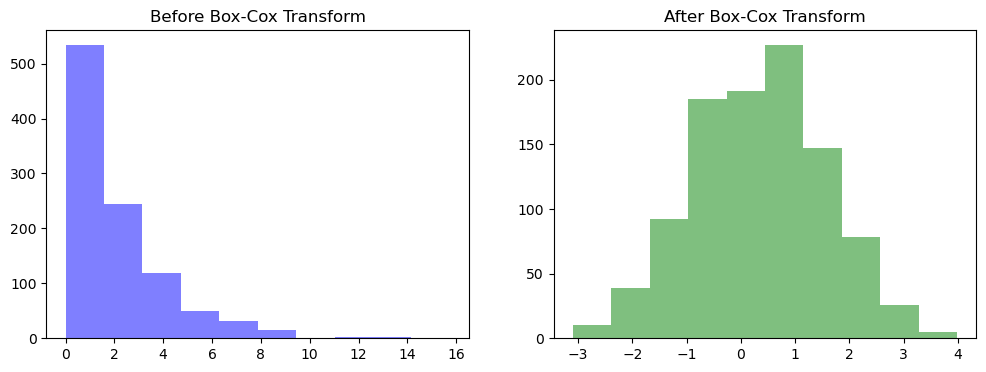

In [57]:
data = np.random.exponential(scale=2, size=1000)
plt.figure(figsize=FIGSIZE)
plt.subplot(1, 2, 1)
plt.hist(data, bins=10, alpha=0.5, color='blue')
plt.title("Before Box-Cox Transform")

transformed_data, lambda_best = stats.boxcox(data)
plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=10, alpha=0.5, color='green')
plt.title("After Box-Cox Transform")
plt.show()

## Portmanteau Test <a name="Portmanteau-Test"></a>
Hypothesis test for the presence of autocorrelation.

[Ljung-Box test of autocorrelation in residuals](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)